In [323]:
from sentinelhub import SHConfig
#записываем айди с сайта, на котором зарегались, в конфиг
INSTANCE_ID = ''  
CLIENT_ID = ''
CLIENT_SECRET = ''
if INSTANCE_ID and CLIENT_ID and CLIENT_SECRET:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    config = None

In [324]:
config.save()

In [325]:
import datetime
from glob import glob
import numpy as np
import gdal
import matplotlib.pyplot as plt
from sentinelhub import WmsRequest, MimeType, CRS, BBox

In [326]:
#просматриваем список возможных источников данных (пусть будет)
from sentinelhub import DataSource
for source in DataSource.get_available_sources():
    print(source)

DataSource.SENTINEL2_L1C
DataSource.SENTINEL2_L2A
DataSource.SENTINEL1_IW
DataSource.SENTINEL1_EW
DataSource.SENTINEL1_EW_SH
DataSource.SENTINEL1_IW_ASC
DataSource.SENTINEL1_EW_ASC
DataSource.SENTINEL1_EW_SH_ASC
DataSource.SENTINEL1_IW_DES
DataSource.SENTINEL1_EW_DES
DataSource.SENTINEL1_EW_SH_DES
DataSource.DEM
DataSource.MODIS
DataSource.LANDSAT8


In [327]:
#задаём координаты местности, которую рассматриваем (Киев)
first_bbox = BBox(bbox=[300000.000, 5600040.000, 409800.000, 5490240.000], crs=CRS.UTM_36N)
second_bbox = BBox(bbox=[300000.000, 5700000.000, 409800.000, 5590200.000], crs=CRS.UTM_36N)

#создаём WmsRequest (загружаем данные)
first_request = WmsRequest(
    #data_sourse = сюда можно дописать источник из списка, но по дефолту стоит то, что нам надо
    layer='BANDS-S2-L2A', 
    bbox=first_bbox,
    time='2019-08-21 09:06:28',    
    width=800,
    height=800,
    image_format=MimeType.TIFF_d32f,
    data_folder="data/", #папка, в которую сохраняем данные
    config=config
)

second_request = WmsRequest(
    layer='BANDS-S2-L2A',
    bbox=second_bbox,
    time='2019-08-21 09:06:13',
    width=800,
    height=800,
    image_format=MimeType.TIFF_d32f,
    data_folder="data/",
    config=config
)

first_request.save_data() 
second_request.save_data()

In [328]:
img1 = first_request.get_data()[0] #get_data возвращает словарь, берем первый его элемент (массив)
img2 = second_request.get_data()[0]

In [329]:
img1 = np.resize(img1, (800, 800)) #т.к. у имг1 shape = (800, 800, 12), 12 - каналы, то график
                                   #построить не получается, поэтому делаем двухмерным
                                   #(так вообще можно делать??)
img1=img1.astype(np.float32)

In [330]:
print(img1, img1.shape)

[[1.     1.     1.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 1.     1.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.1175 0.3249 0.4038 ... 0.3043 0.2187 0.1247]
 [0.0436 0.0441 0.0701 ... 0.1857 0.2106 0.2457]
 [0.241  0.2922 0.2763 ... 0.0289 0.0586 0.0361]] (800, 800)


In [331]:
plt.figure(figsize=(20,20)) #задаём размеры картинки

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [332]:
#смотрим, что возвращается (массив иён файлов с именем response.tiff)
glob("data/*/response.tiff")

['data\\3dfb7c5cabc7f0e1bedff5ee6bc20768\\response.tiff',
 'data\\b1cf9b811418ccbb32316a5f62cfc7b7\\response.tiff',
 'data\\bc99482db7c75f32517f7f79d0426cc7\\response.tiff',
 'data\\ff6f17ec04fc1f7261f45f427ab0a1e4\\response.tiff']

In [333]:
#gdal.Open вернёт датасет
gdalData1 = gdal.Open(glob("data/*/response.tiff")[0])
gdalData2 = gdal.Open(glob("data/*/response.tiff")[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


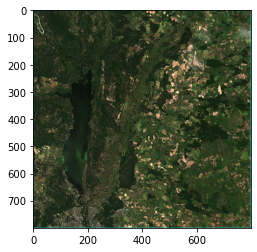

In [336]:
plt.imshow(np.dstack([gdalData1.GetRasterBand(i).ReadAsArray() for i in [4,3,2]])*4)
#изображение для первого датасета

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


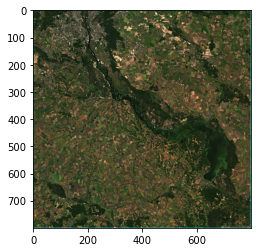

In [338]:
plt.imshow(np.dstack([gdalData2.GetRasterBand(i).ReadAsArray() for i in [4,3,2]])*4)
#и для второго

In [ ]:
#создаём виртуальный датасет,чтобы слить несколько растровых файлов в один
#по сути, мы склеиваем две картинки
vrt = gdal.BuildVRT("data/Kyiv.vrt", glob("data/*/response.tiff"))
#переводим этот датасет в формат тифф, чтобы с ним можно было работать, как с изображением, с помощью gdal
#теперь у нас есть картинка, склеенная из двух, с расширением tiff
img1 = gdal.Translate("data/Sentinel.tiff", vrt)

In [ ]:
gdalData = gdal.Open("data/Sentinel.tiff")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


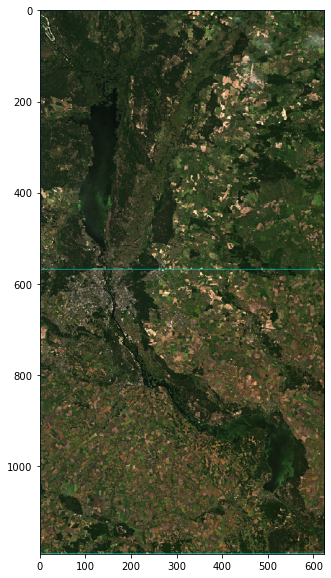

In [345]:
plt.figure(figsize=(20,10))
plt.imshow(np.dstack([gdalData.GetRasterBand(i).ReadAsArray() for i in [4,3,2]])*4)
#изображение для общего датасета 
#GetRasterBand - получение отдельного канала 
#gdalData.ReadAsArray() - получение всего растра целиком